In [1]:
import sys
sys.path.append("..")

In [2]:
import glob
import html
import os
from pathlib import Path

import chromadb
import lovely_tensors as lt
import ollama
import torch
from dotenv import load_dotenv
from langchain.chat_models.openai import ChatOpenAI
from langchain_community.chat_models import ChatOllama, ChatOpenAI
from langchain_community.document_loaders.wikipedia import WikipediaLoader
from langchain_community.graphs import Neo4jGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_text_splitters import TokenTextSplitter
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
from transformers import AutoTokenizer, CLIPModel, CLIPProcessor
from unidecode import unidecode

from llavart.data.datasets.image_text_dataset import ImageTextDataset
from llavart.models.prompting import *
from llavart.models.graph_retriever.inference import GraphRetrieverInference
from llavart.models.graph_retriever.ops import load_model
from llavart.models.retriever.modeling import MultiModalSentEmbedder
from llavart.utils.dirutils import (
    get_data_dir,
    get_model_checkpoints_dir,
    get_store_dir,
)
from llavart.data.graph.ops import get_nodes_by_id

lt.monkey_patch()
load_dotenv()

/home/nicola/miniconda3/envs/vitart/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [3]:
IMG_DIR = Path("../data") / "images-hd"
img_paths = list(IMG_DIR.glob("*.jpg"))

In [4]:
img_paths = [path for path in img_paths if "van-gogh" in str(path)]

In [5]:
num_img = 102

In [6]:
img_paths[num_img]

Path('../data/images-hd/vincent-van-gogh_the-tarascon-diligence-1888.jpg')

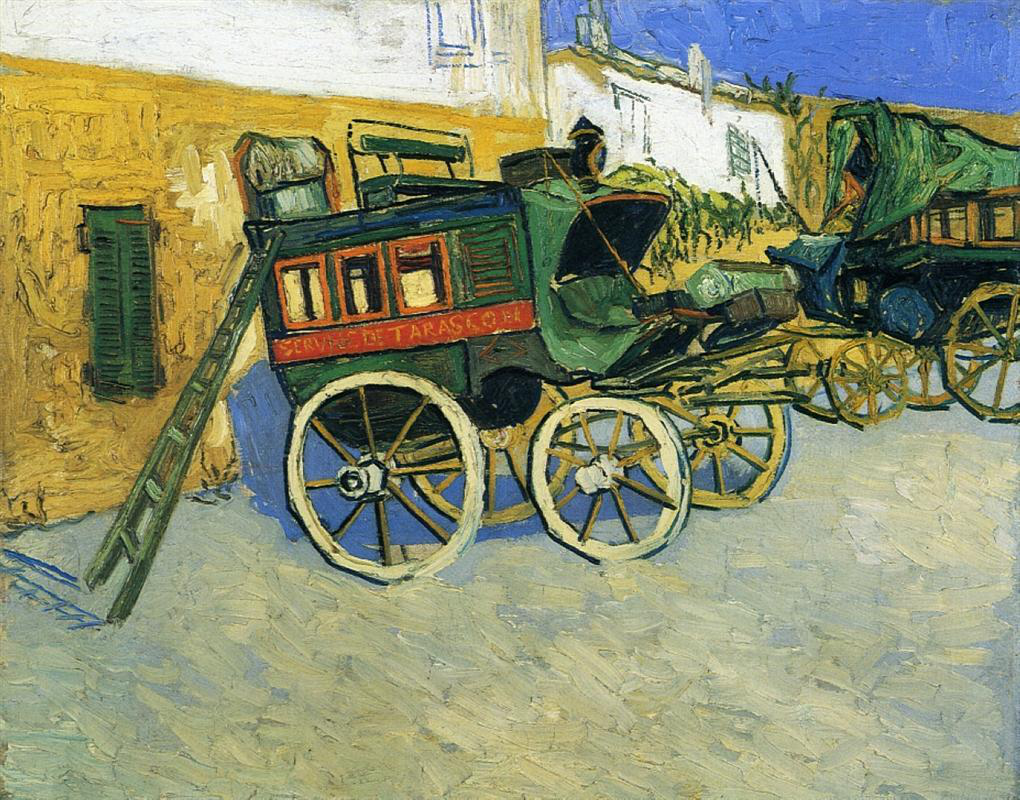

In [7]:
img = Image.open(img_paths[num_img])
img

In [8]:
chroma_client = chromadb.PersistentClient(str(get_store_dir()))
collection = chroma_client.get_collection(os.getenv("TEXT_FEATURES_COLLECTION_NAME"))
collection

Collection(name=text_features)

In [9]:
model = MultiModalSentEmbedder("sentence-transformers/all-MiniLM-L12-v2", "openai/clip-vit-base-patch32", clip_dtype=torch.float32)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

/home/nicola/miniconda3/envs/vitart/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


MultiModalSentEmbedder(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512

In [10]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

In [11]:
transform1 = Compose([Resize(224), CenterCrop(224), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform2 = Compose([Resize(336), CenterCrop(336), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = ImageTextDataset(
    get_data_dir() / "texts" / "wiki_img_paragraph_clean.csv",
    get_data_dir() / "wikipedia_images",
    split="val",
    transform=transform1,
)

In [12]:
transr = load_model(get_model_checkpoints_dir() / "graph_retriever" / "results" / "TransR").to(device)

In [13]:
state_dict = {}
# load all pytorch_model*.bin files into the state dict
for file in glob.glob(str(get_model_checkpoints_dir() / "retriever" / "frosty-armadillo-2" / "best" / "pytorch_model*.bin")):
    state_dict.update(torch.load(file))
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['temperature'])

In [14]:
clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336").to(device)

/home/nicola/miniconda3/envs/vitart/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
graph = Neo4jGraph()
graph_retriever = GraphRetrieverInference(
    transr,
    clip,
    graph,
    transform2
)

In [16]:
style = graph_retriever.predict_link([img], "Style", "hasStyle")

In [17]:
artist = graph_retriever.predict_link([img], "Artist", "createdBy") 

In [18]:
style = get_nodes_by_id(graph, style)

In [19]:
artist = get_nodes_by_id(graph, artist)

In [58]:
style, artist

([{'n': {'summary': 'Post-Impressionism (also spelled Postimpressionism) was a predominantly French art movement that developed roughly between 1886 and 1905, from the last Impressionist exhibition to the birth of Fauvism. Post-Impressionism emerged as a reaction against Impressionists\' concern for the naturalistic depiction of light and colour. Its broad emphasis on abstract qualities or symbolic content means Post-Impressionism encompasses Les Nabis, Neo-Impressionism, Symbolism, Cloisonnism, the Pont-Aven School, and Synthetism, along with some later Impressionists\' work. The movement\'s principal artists were Paul Cézanne (known as the father of Post-Impressionism), Paul Gauguin, Vincent van Gogh and Georges Seurat.The term Post-Impressionism was first used by art critic Roger Fry in 1906. Critic Frank Rutter in a review of the Salon d\'Automne published in Art News, 15 October 1910, described Othon Friesz as a "post-impressionist leader"; there was also an advert for the show Th

In [59]:
style_name = style[0]["n"]["name"]
artist_name = artist[0]["n"]["printed_name"]

In [73]:
info = f"Van Gogh {style_name} Question:"
question = f"When was this done?"
iq = f"{info} {question}"

In [74]:
pixel_values = transform1(img).unsqueeze(0).to(device)
embedding = model(pixel_values=pixel_values, **tokenizer(iq, return_tensors="pt", padding=True, truncation=True).to(device))
embedding

tensor[1, 384] 1.5Kb x∈[-0.183, 0.192] μ=-0.001 σ=0.051 grad DivBackward0 cuda:0

In [75]:
embedding = embedding.squeeze(0).cpu().tolist()
res = collection.query(query_embeddings=[embedding], n_results=3)

In [76]:
documents = res["documents"][0]
documents

['Towards the end of the 19th century, several young painters took impressionism a stage further, using geometric forms and unnatural color to depict emotions while striving for deeper symbolism. Of particular note are Paul Gauguin, who was strongly influenced by Asian, African and Japanese art, Vincent van Gogh, a Dutchman who moved to France where he drew on the strong sunlight of the south, and Toulouse-Lautrec, remembered for his vivid paintings of night life in the Paris district of Montmartre.',
 'Impressionism, postimpressionism, and early modern art [all oil on canvas unless noted otherwise]',
 'In 1890, Vincent van Gogh died. It was during the 1890s that his paintings achieved the admiration denied them during his life; first among other artists, then gradually among the public. Reactions against the ideals of the Impressionists characterised visual arts in Paris during the Belle Ã\x89poque. Among the post-Impressionist movements in Paris were the Nabis, the Salon de la Rose 

In [77]:
context = "\n".join(documents)
context = f"""
{context}
"""
messages = [
    {"role": "system", "content": f"You are a helpful AI that can answer questions about art. When possible, use the following texts to help you answer:\n{context}"},
]

In [78]:
user_message = {"role": "user", "content": question, "images": [img_paths[num_img]]}
new_messages = messages + [user_message]

In [79]:
new_messages

[{'role': 'system',
  'content': 'You are a helpful AI that can answer questions about art. When possible, use the following texts to help you answer:\n\nTowards the end of the 19th century, several young painters took impressionism a stage further, using geometric forms and unnatural color to depict emotions while striving for deeper symbolism. Of particular note are Paul Gauguin, who was strongly influenced by Asian, African and Japanese art, Vincent van Gogh, a Dutchman who moved to France where he drew on the strong sunlight of the south, and Toulouse-Lautrec, remembered for his vivid paintings of night life in the Paris district of Montmartre.\nImpressionism, postimpressionism, and early modern art [all oil on canvas unless noted otherwise]\nIn 1890, Vincent van Gogh died. It was during the 1890s that his paintings achieved the admiration denied them during his life; first among other artists, then gradually among the public. Reactions against the ideals of the Impressionists char

In [80]:
res = ollama.chat(
	model="llava:13b",
	messages=new_messages,
    options={
        "temperature": 0.1,
        "seed": 42,
        "num_predict": 1024,
    }
)

print(res['message']['content'])

 The painting you've shown is "The Sower" by Vincent van Gogh, painted in 1888. It depicts a horse-drawn cart on a street, which suggests it was created during the late 19th century when such vehicles were still common.
